# DeepDISC Formatted DP1 Data

Before perusing this notebook, take a look at the `DP1_Access.ipynb` to understand what DP1 data is and what subset of DP1 we are grabbing. `DP1_Access.ipynb` creates **three main data products per patch**:

### 1. Image Cutouts (`.npy` files)
- **Format**: NumPy array 
- **Shape**: `(6, 3400, 3400)` - 6 bands × 3400 pixels × 3400 pixels
- **Bands**: u, g, r, i, z, y (LSST photometric bands)
- **Filename pattern**: `full_p{patch_id}.npy`
- **Example**: `full_p24.npy`, `full_p25.npy`, etc.

### 2. Object Catalogs (`.json` files)
- **Format**: JSON (pandas DataFrame exported as records)
- **Filename pattern**: `full_p{patch_id}.json`
- **Example**: `full_p24.json`, `full_p25.json`, etc.

Catalog Columns (32 total):
- **Positional**: `coord_ra`, `coord_dec`, `cutout_x`, `cutout_y` (pixels, origin at bottom-left)
- **Identifiers**: `objectId`, `parentObjectId`, `tract`, `patch`
- **Morphology**: `refExtendedness`, `shape_xx`, `shape_xy`, `shape_yy`
- **Reference info**: `refBand`, `x`, `y`
- **Deblending flags**: `i_blendedness`, `deblend_failed`, `deblend_skipped`, `deblend_nChild`, `detect_fromBlend`, `detect_isIsolated`, `detect_isDeblendedModelSource`
- **Photometry** (12 columns): For each band (u, g, r, i, z, y):
  - `{band}_cModelFlux`
  - `{band}_cModelFluxErr`
- **Derived**: `mag_u`, `mag_g`, `mag_r`, `mag_i`, `mag_z`, `mag_y`

**Filtering Applied**:
 - Only primary detections (`deblend_nChild == 0`)
 - Objects within patch boundaries
 - Spatial overlap with HST CANDELS GOODS-S footprint

**Photometric Calibration**:
 - Zero point: 31.4 mag
 - Fluxes in nanomaggies
 - Magnitudes computed as: `mag = 31.4 - 2.5 * log10(flux)`

### 3. WCS Headers (`wcs_dp1.json`)
- **Format**: Single JSON file containing WCS information for all patches
- **Structure**: Dictionary with patch IDs as keys
- **Content**: FITS header metadata for coordinate transformations
- **Location**: `/global/homes/y/yaswante/wcs_dp1.json`

## File/Folder Structure

```
/global/homes/y/yaswante/
├── full_p24.npy          # Image cutout for patch 24 (6 bands)
├── full_p24.json         # Object catalog for patch 24
├── full_p25.npy          # Image cutout for patch 25
├── full_p25.json         # Object catalog for patch 25
├── full_p34.npy          # Image cutout for patch 34
├── full_p34.json         # Object catalog for patch 34
├── full_p35.npy          # Image cutout for patch 35
├── full_p35.json         # Object catalog for patch 35
├── full_p44.npy          # Image cutout for patch 44
├── full_p44.json         # Object catalog for patch 44
├── full_p45.npy          # Image cutout for patch 45
├── full_p45.json         # Object catalog for patch 45
├── wcs_dp1.json          # WCS headers for all patches
└── lsst_dets_hst.json    # Master catalog (all patches combined)
```
The final data represents LSST DP1 detections matched to HST coverage in the GOODS-South field. 

This following notebook will demonstrate how I cut the 6 patches of tract 5063 from DP1 (24, 25, 34, 35, 44, 45) that overlap with the HST objects into 128x128 cutouts. 

# Imports

In [1]:
import json, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.visualization import AsinhStretch, ImageNormalize
def asinh_norm(data, a=0.1):
    finite_data = data[np.isfinite(data)] # ensure no NaN or inf vals
    if len(finite_data) == 0:
        return ImageNormalize(vmin=0, vmax=1, stretch=AsinhStretch(a=a))
    # percentile-based limits
    vmin, vmax = np.percentile(finite_data, [1, 99])
    return ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch(a=a))

In [3]:
all_wcs = json.load(open(f'{os.path.expanduser("~")}/dp1/wcs_dp1.json', 'r'))

# Visualizing Patches

In [4]:
BANDS = {'u': 0, 'g': 1, 'r': 2, 'i': 3, 'z': 4, 'y': 5}
chosen_band = 'i'  # example band to visualize
def load_img(patch_id, band='i'):
    data = np.load(f'full_p{patch_id}.npy')  # (6, H, W)
    return data[BANDS[band]]
patch_ids = [34, 35]
imgs = {pid: load_img(pid, band=chosen_band) for pid in patch_ids}

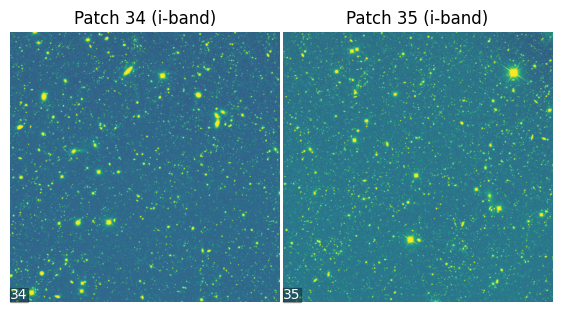

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(7, 7), sharex=True, sharey=True, gridspec_kw={'wspace': 0.01, 'hspace': 0.01})
for idx, (pid, img) in enumerate(imgs.items()):
    ax = axes[idx]
    ax.set_title(f'Patch {pid} ({chosen_band}-band)')
    ax.imshow(img, norm=asinh_norm(img, a=0.1), origin='lower', cmap='viridis')
    ax.text(5, 5, f'{pid}', color='white', fontsize=10,
        ha='left', va='bottom', bbox=dict(facecolor='black', alpha=0.3, pad=0.01))
    ax.axis('off')
# fig.suptitle(f'LSST {chosen_band}-band Coadds for Overlapping Patches', fontsize=16)

As you can see, our patches have some overlap on the right side of the patch. The two bright galaxies in the middle right of Patch 34 also exist in Patch 35. This overlap exists with all 6 patches. Thus, we ensure that our cutouts have no overlapping pixels by only taking the center of the patch so objects aren't repeated in our catalogs. Before we do that, let's find out how many pixels actually do overlap.

## How much Overlap between Patches?

In [5]:
ny34, nx34 = imgs[34].shape
ny35, nx35 = imgs[35].shape
w34, w35 = WCS(all_wcs['34']), WCS(all_wcs['35'])
# 1. Corners of each patch in pixel coords
corners34_pix = np.array([
    [0,       0      ],
    [nx34-1,  0      ],
    [nx34-1,  ny34-1 ],
    [0,       ny34-1 ]
])
corners35_pix = np.array([
    [0,       0      ],
    [nx35-1,  0      ],
    [nx35-1,  ny35-1 ],
    [0,       ny35-1 ]
])
# 2. Convert corners to sky (RA, Dec)
corners34_sky = w34.pixel_to_world(corners34_pix[:,0], corners34_pix[:,1])
corners35_sky = w35.pixel_to_world(corners35_pix[:,0], corners35_pix[:,1])
# 3. Bounding box in sky coordinates (ICRS)
ra34 = corners34_sky.ra.wrap_at(180*u.deg)
dec34 = corners34_sky.dec
ra35 = corners35_sky.ra.wrap_at(180*u.deg)
dec35 = corners35_sky.dec

ra_min_34, ra_max_34 = ra34.min(), ra34.max()
dec_min_34, dec_max_34 = dec34.min(), dec34.max()
ra_min_35, ra_max_35 = ra35.min(), ra35.max()
dec_min_35, dec_max_35 = dec35.min(), dec35.max()

# 4. Overlap box in sky
ra_min_overlap = np.maximum(ra_min_34, ra_min_35)
ra_max_overlap = np.minimum(ra_max_34, ra_max_35)
dec_min_overlap = np.maximum(dec_min_34, dec_min_35)
dec_max_overlap = np.minimum(dec_max_34, dec_max_35)

if (ra_max_overlap <= ra_min_overlap) or (dec_max_overlap <= dec_min_overlap):
    print("No sky overlap detected between patches 34 and 35")
else:
    # 5. Sample the overlap box corners in sky
    overlap_corners_sky = SkyCoord(
        ra=[ra_min_overlap, ra_max_overlap, ra_max_overlap, ra_min_overlap],
        dec=[dec_min_overlap, dec_min_overlap, dec_max_overlap, dec_max_overlap],
        frame='icrs'
    )
    # 6. Convert overlap corners back to each patch's pixel coords
    ox34_x, ox34_y = w34.world_to_pixel(overlap_corners_sky)
    ox35_x, ox35_y = w35.world_to_pixel(overlap_corners_sky)
    # Pixel bounding box for overlap in each image
    x34_min, x34_max = ox34_x.min(), ox34_x.max()
    y34_min, y34_max = ox34_y.min(), ox34_y.max()
    x35_min, x35_max = ox35_x.min(), ox35_x.max()
    y35_min, y35_max = ox35_y.min(), ox35_y.max()
    # 7. Clip to image bounds and compute integer sizes for patch 34
    x34_min_i = max(int(np.floor(x34_min)), 0)
    x34_max_i = min(int(np.ceil(x34_max)), nx34)
    y34_min_i = max(int(np.floor(y34_min)), 0)
    y34_max_i = min(int(np.ceil(y34_max)), ny34)
    width34  = x34_max_i - x34_min_i
    height34 = y34_max_i - y34_min_i
    n_pix34  = max(width34, 0) * max(height34, 0)
    
    # 8. Clip to image bounds and compute integer sizes for patch 35
    x35_min_i = max(int(np.floor(x35_min)), 0)
    x35_max_i = min(int(np.ceil(x35_max)), nx35)
    y35_min_i = max(int(np.floor(y35_min)), 0)
    y35_max_i = min(int(np.ceil(y35_max)), ny35)
    width35  = x35_max_i - x35_min_i
    height35 = y35_max_i - y35_min_i
    n_pix35  = max(width35, 0) * max(height35, 0)

    print("="*70)
    print("OVERLAP ANALYSIS: Patches 34 and 35")
    print("="*70)
    print(f"\nPatch 34 ({nx34}×{ny34} pixels):")
    print(f"  Overlap region: x=[{x34_min_i}, {x34_max_i}), y=[{y34_min_i}, {y34_max_i})")
    print(f"  Overlap dimensions: {width34} × {height34} pixels")
    print(f"  Total overlap pixels: {n_pix34:,}")
    print(f"  Fraction of patch 34: {100*n_pix34/(nx34*ny34):.1f}%")
    print(f"  --> Right edge: last {width34} columns overlap with patch 35")
    
    print(f"\nPatch 35 ({nx35}×{ny35} pixels):")
    print(f"  Overlap region: x=[{x35_min_i}, {x35_max_i}), y=[{y35_min_i}, {y35_max_i})")
    print(f"  Overlap dimensions: {width35} × {height35} pixels")
    print(f"  Total overlap pixels: {n_pix35:,}")
    print(f"  Fraction of patch 35: {100*n_pix35/(nx35*ny35):.1f}%")
    print(f"  --> Left edge: first {width35} columns overlap with patch 34")
    
    print(f"\nOverlap summary:")
    print(f"  Width: {width34} pixels ({width34:.1f} px ≈ {width34/2:.0f} px per edge)")
    print(f"  Height: {height34} pixels (full image height)")
    print(f"\nCONCLUSION: Soo, we should exclude 200 px from each edge to avoid this overlap and have a core region.")

OVERLAP ANALYSIS: Patches 34 and 35

Patch 34 (3400×3400 pixels):
  Overlap region: x=[2999, 3400), y=[0, 3400)
  Overlap dimensions: 401 × 3400 pixels
  Total overlap pixels: 1,363,400
  Fraction of patch 34: 11.8%
  --> Right edge: last 401 columns overlap with patch 35

Patch 35 (3400×3400 pixels):
  Overlap region: x=[0, 400), y=[0, 3400)
  Overlap dimensions: 400 × 3400 pixels
  Total overlap pixels: 1,360,000
  Fraction of patch 35: 11.8%
  --> Left edge: first 400 columns overlap with patch 34

Overlap summary:
  Width: 401 pixels (401.0 px ≈ 200 px per edge)
  Height: 3400 pixels (full image height)

CONCLUSION: Soo, we should exclude 200 px from each edge to avoid this overlap and have a core region.


## Core Region and Cutout Grid

Text(0.5, 0.75, 'Patches 34,35 (i-band) with core region (no 200px overlap)')

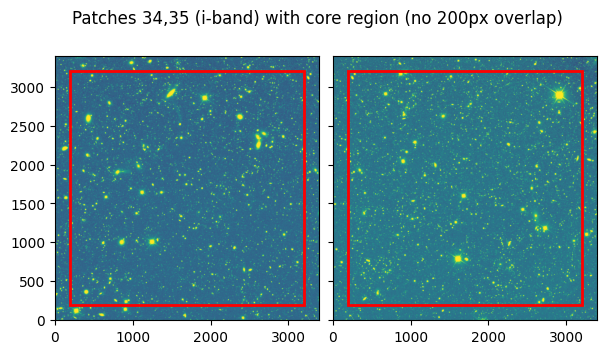

In [6]:
overlap_pixels = 200
h, w = imgs[34].shape
usable_width = w - 2 * overlap_pixels
usable_height = h - 2 * overlap_pixels
start_x, start_y = overlap_pixels, overlap_pixels

fig, axes = plt.subplots(1, 2, figsize=(7, 7), sharex=True, sharey=True, gridspec_kw={'wspace': 0.05, 'hspace': 0.3})
for idx, (pid, img) in enumerate(imgs.items()):
    ax = axes[idx]
    ax.imshow(img, norm=asinh_norm(img, a=0.1), origin='lower', cmap='viridis')
    rect = plt.Rectangle((start_x, start_y),
                     usable_width, usable_height,
                     edgecolor='red', facecolor='none', lw=2)
    ax.add_patch(rect)
fig.suptitle(f"Patches {','.join(str(pid) for pid in patch_ids)} ({chosen_band}-band) with core region (no 200px overlap)", y=0.75)
    # ax.axis('off')
# show core region and then how many cutouts for each patch
# inset of a single cutout from patch 34

Since the model we will use was trained on LSST DC2 simulated images of size 160, let's try to stick to a size close to 160. We'll go with 128x128. Then, how many cutouts will we have given we want cutouts of size 128x128?

Text(0.5, 1.0, 'Patch 34 with 23x23 cutout grid')

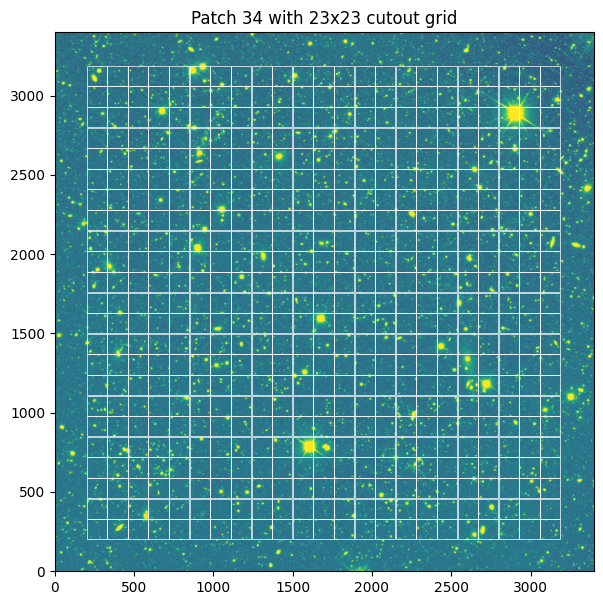

In [67]:
pid = 34
cutout_size = 128
h, w = imgs[pid].shape
# only use the core region avoiding 200px overlap on each edge
usable_width = w - 2 * overlap_pixels # 3000
usable_height = h - 2 * overlap_pixels # 3000
start_x, start_y = overlap_pixels, overlap_pixels # 200, 200
nx_cutouts = usable_width // cutout_size # 3000 // 128 = 23
ny_cutouts = usable_height // cutout_size # 3000 // 128 = 23
# calc spacing to distribute cutouts evenly
if nx_cutouts > 1:
    x_spacing = (usable_width - cutout_size) // (nx_cutouts - 1)
else:
    x_spacing = 0
if ny_cutouts > 1:
    y_spacing = (usable_height - cutout_size) // (ny_cutouts - 1)
else:
    y_spacing = 0

centers = []
for i in range(ny_cutouts):
    for j in range(nx_cutouts):
        if ny_cutouts == 1:
            y_center = start_y + cutout_size // 2
        else:
            y_center = start_y + cutout_size // 2 + i * y_spacing

        if nx_cutouts == 1:
            x_center = start_x + cutout_size // 2
        else:
            x_center = start_x + cutout_size // 2 + j * x_spacing
        centers.append((x_center, y_center))

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, norm=asinh_norm(img, a=0.1), origin='lower', cmap='viridis')
for (xc, yc) in centers:
    rect = plt.Rectangle((xc - cutout_size//2, yc - cutout_size//2),
                         cutout_size, cutout_size,
                         edgecolor='white', facecolor='none', lw=0.5)
    ax.add_patch(rect)

ax.set_title(f'Patch {pid} with {nx_cutouts}x{ny_cutouts} cutout grid')

Great! So, we'll have 23x23 = 529 cutouts per patch if we have a cutout size of 128x128 pixels. With 6 patches, we'll have a total of 3174 cutouts. Now, let's move on to actually create all of these cutouts and save them to disk.

# Cutout and Catalog Creation

From `DP1_Access.ipynb`, we know the DP1 data that overlaps with HST
is in a single tract within 6 patches. So, we'll just create a folder for each 
patch called `p{patch_id}` and save each patch's cutout within this folder. Because we won't have that many cutouts (~3k), we can just save each cutout's metadata in a single file called `test.json`. This will contain at minimum the filename, height and width of the cutout, patch the cutout belongs to and the cutout's WCS. The final folder structure should look like this:

```
dp1/
├── p24/
├── p25/
├── p34/
├── p35/
├── p44/
├── p45/
├── prep_dp1_for_dd.ipynb
├── prep_dp1_for_dd.py
├── deepdisc_dp1.ipynb
├── dp1.ipynb
├── full_p24.json
├── full_p24.npy
├── full_p25.json
├── full_p25.npy
├── full_p34.json
├── full_p34.npy
├── full_p35.json
├── full_p35.npy
├── full_p44.json
├── full_p44.npy
├── full_p45.json
├── full_p45.npy
├── lsst_dets_hst.json
├── test.json
└── wcs_dp1.json
```


## Single Cutout

Let's write a function for a single cutout within a patch.

In [10]:
def create_single_cutout(patch_id, row, col, w, cutout_size=128):
    patch_cutout = f'full_p{patch_id}.npy'
    full_img_data = np.load(patch_cutout)
    coadd_size = full_img_data.shape[1:] 
    overlap_pixels = 200
    # only use the core region avoiding 200px overlap on each edge
    usable_width = coadd_size[1] - 2 * overlap_pixels  # 3000
    usable_height = coadd_size[0] - 2 * overlap_pixels  # 3000
    start_x, start_y = overlap_pixels, overlap_pixels  # 200, 200
    
    nx_cutouts = usable_width // cutout_size # 3000 // 128 = 23
    ny_cutouts = usable_height // cutout_size # 3000 // 128 = 23
        
    # calc spacing to distribute cutouts evenly
    if nx_cutouts > 1:
        x_spacing = (usable_width - cutout_size) // (nx_cutouts - 1)
    else:
        x_spacing = 0
    
    if ny_cutouts > 1:
        y_spacing = (usable_height - cutout_size) // (ny_cutouts - 1)
    else:
        y_spacing = 0
    
    #     print(f"Creating cutouts for {ra_dec[0]}_{ra_dec[1]}...")
    print(f"Image size: {coadd_size[1]}x{coadd_size[0]}")
    print(f"Usable region: {usable_width}x{usable_height} (starting at {start_x},{start_y})")
    print(f"Cutouts: {nx_cutouts}x{ny_cutouts} = {nx_cutouts * ny_cutouts} total")
    print(f"Spacing: x={x_spacing}, y={y_spacing}")
    # cutout center pos
    # for this example, just select the center cutout
    if ny_cutouts == 1:
        y_center = start_y + cutout_size // 2
    else:
        y_center = start_y + cutout_size // 2 + row * y_spacing
    
    if nx_cutouts == 1:
        x_center = start_x + cutout_size // 2
    else:
        x_center = start_x + cutout_size // 2 + col * x_spacing
    
    cutout_id = row * nx_cutouts + col
    # full_cutout_path = f'p{patch_id}/full_c{cutout_id}.npy'
    # if not os.path.exists(full_cutout_path):
    # all 6 bands
    raw_cutout_u = Cutout2D(full_img_data[0, :, :], position=(x_center, y_center), 
                            size=cutout_size, wcs=w, mode='partial', fill_value=0)
    raw_cutout_g = Cutout2D(full_img_data[1, :, :], position=(x_center, y_center), 
                            size=cutout_size, wcs=w, mode='partial', fill_value=0)
    raw_cutout_r = Cutout2D(full_img_data[2, :, :], position=(x_center, y_center), 
                            size=cutout_size, wcs=w, mode='partial', fill_value=0)
    raw_cutout_i = Cutout2D(full_img_data[3, :, :], position=(x_center, y_center), 
                            size=cutout_size, wcs=w, mode='partial', fill_value=0)
    raw_cutout_z = Cutout2D(full_img_data[4, :, :], position=(x_center, y_center), 
                            size=cutout_size, wcs=w, mode='partial', fill_value=0)
    raw_cutout_y = Cutout2D(full_img_data[5, :, :], position=(x_center, y_center), 
                            size=cutout_size, wcs=w, mode='partial', fill_value=0)
    full_raw_cutout = np.stack((
        raw_cutout_u.data,
        raw_cutout_g.data,
        raw_cutout_r.data,
        raw_cutout_i.data,
        raw_cutout_z.data,
        raw_cutout_y.data
    ))
    # np.save(full_cutout_path, full_raw_cutout)
    return full_raw_cutout, raw_cutout_i.wcs, cutout_id
    # we can get the wcs by doing raw_cutout_i.wcs.to_header_string()
    # wcs_header = raw_cutout_i.wcs.to_header_string()
    # with open(f'p{patch_id}/wcs_c{counter}.wcs', 'w') as f:
    #     f.write(wcs_header)

In [26]:
pid = 34
# pid = 35
row, col = 11, 11
# row, col = 0, 12
wcs34 = WCS(all_wcs[str(pid)])
# change this if you want larger/smaller cutouts, but 128 is good for the DeepDISC model trained on 160x160 simulated LSST data
cutout_size = 128
cutout, cutout_wcs, cid = create_single_cutout(pid, row, col, wcs34, cutout_size=cutout_size)

Image size: 3400x3400
Usable region: 3000x3000 (starting at 200,200)
Cutouts: 23x23 = 529 total
Spacing: x=130, y=130


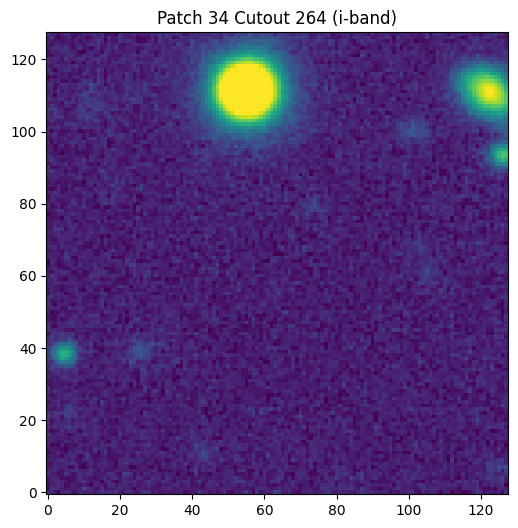

In [27]:
plt.figure(figsize=(6,6))
plt.title(f'Patch {pid} Cutout {cid} (i-band)')
plt.imshow(cutout[3], origin='lower', cmap='viridis', norm=asinh_norm(cutout[3], a=0.1))

## Single Cutout's LSST Pipeline Detection Catalog

Now, let's also cut the LSST Pipeline's detection catalog within this patch using the cutout's WCS.

In [28]:
patch_cat = pd.read_json(f'full_p{pid}.json', orient='records')
patch_cat

,coord_ra,coord_dec,refExtendedness,tract,objectId,parentObjectId,shape_xx,shape_xy,shape_yy,refBand,...,y_cModelFlux,y_cModelFluxErr,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y,cutout_x,cutout_y
0,53.210373,-27.850026,0.0,5063,611255759837079743,611255759837069315,4.354516,0.066300,3.909597,i,...,149947.000000,374.081360,25.001827,22.192846,20.852829,19.408054,18.764172,18.460155,1244.336670,269.385742
1,53.217190,-27.852482,1.0,5063,611255759837079744,611255759837069315,12.543857,-0.734766,8.414174,i,...,38447.613281,574.496277,22.107208,20.934917,20.403015,20.093081,20.019201,19.937826,1135.901731,225.071086
2,53.220334,-27.849735,0.0,5063,611255759837079745,611255759837069315,4.386615,0.058506,3.914943,i,...,8541.523438,326.433380,23.313761,22.367027,21.875982,21.679628,21.623562,21.571161,1085.812128,274.453244
3,53.222632,-27.847632,1.0,5063,611255759837079746,611255759837069315,19.322552,-4.541801,10.574187,i,...,16402.078125,522.391968,22.178425,22.204212,21.416290,21.190453,21.082394,20.862751,1049.194230,312.278784
4,53.218044,-27.847796,1.0,5063,611255759837079749,611255759837069315,10.847188,-4.410918,9.379762,i,...,10379.309570,447.234344,25.202988,24.087866,22.705620,21.995396,21.565598,21.359577,1122.221537,309.413020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11058,53.266683,-27.693604,1.0,5063,611255759837096229,611255759837075967,34.031879,2.714846,9.296775,u,...,215.353363,594.229248,24.492340,27.964493,NaN,29.691166,27.752411,25.567120,344.084194,3083.944318
11059,53.151052,-27.691091,NaN,5063,611255759837096239,611255759837075977,NaN,NaN,NaN,u,...,-100.739861,467.039001,24.442858,NaN,NaN,28.414482,26.157106,NaN,2187.000000,3130.999999
11060,53.151993,-27.690646,NaN,5063,611255759837096240,611255759837075977,NaN,NaN,NaN,u,...,-273.612732,474.300598,24.741779,NaN,NaN,NaN,27.311726,NaN,2172.000000,3139.000000
11061,53.262673,-27.688315,1.0,5063,611255759837096244,611255759837075981,6.624916,-6.002718,73.308266,u,...,1221.904785,711.331604,24.113319,NaN,28.143133,27.316910,28.850651,23.682407,407.854940,3179.246953


In [39]:
cutout_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : np.float64(53.08755760368661) np.float64(-27.520661157024808) 
CRPIX : np.float64(1570.0) np.float64(4570.0) 
CD1_1 CD1_2  : np.float64(-5.555555555555553e-05) np.float64(0.0) 
CD2_1 CD2_2  : np.float64(0.0) np.float64(5.5555555555557056e-05) 
NAXIS : 128  128

In [32]:
# Convert catalog RA/Dec to pixels using cutout wcs
coords = SkyCoord(ra=patch_cat['coord_ra'].values * u.deg,
                  dec=patch_cat['coord_dec'].values * u.deg)
# When we use Cutout2D, the returned WCS (cutout_wcs) uses a new pixel coordinate system where the cutout's corner is at (0, 0), not the OG image coordinates. Thus, the below world to pixel returns pixel coords in the cutout's coordinate system (0 to 128).
patch_xpix, patch_ypix = cutout_wcs.world_to_pixel(coords)
# Check if within cutout bounds (0 to cutout_size)
in_cutout = ((patch_xpix >= 0) & (patch_xpix < cutout_size) & 
             (patch_ypix >= 0) & (patch_ypix < cutout_size))
cutout_xpix, cutout_ypix = patch_xpix[in_cutout], patch_ypix[in_cutout]
print(f"Found {len(cutout_xpix)} catalog objects in cutout {cid} from Patch {pid}")

Found 22 catalog objects in cutout 264 from Patch 34


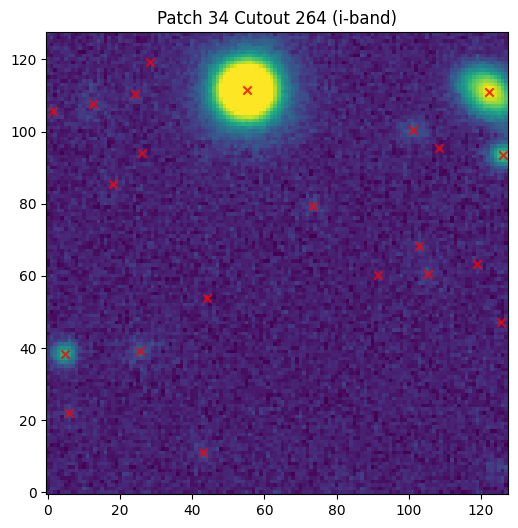

In [30]:
# patch = np.load(f'full_p{pid}.npy')[3]
# plt.figure(figsize=(6,6))
# plt.imshow(patch, origin='lower', cmap='viridis', norm=asinh_norm(patch, a=0.1))
# plt.scatter(patch_cat['cutout_x'], patch_cat['cutout_y'], marker='x', color=['red'], alpha=0.8, label='LSST Pipeline Detections')

plt.figure(figsize=(6,6))
plt.title(f'Patch {pid} Cutout {cid} (i-band)')
plt.imshow(cutout[3], origin='lower', cmap='viridis', norm=asinh_norm(cutout[3], a=0.1))
plt.scatter(cutout_xpix, cutout_ypix, marker='x', color=['red'], alpha=0.8, label='LSST Pipeline Detections')

## Saving All Cutouts and their Metadata from All Patches

In [33]:
def create_cutouts(patch_id, patch_wcs, cutout_size=128):
    patch_cutout = f'full_p{patch_id}.npy'
    full_img_data = np.load(patch_cutout)
    
    # read in patch catalog and then turn coords into SkyCoords
    full_cat = pd.read_json(f'full_p{patch_id}.json', orient='records')
    coords = SkyCoord(ra=full_cat['coord_ra'].values * u.deg,
                      dec=full_cat['coord_dec'].values * u.deg)
    
    coadd_size = full_img_data.shape[1:] 
    overlap_pixels = 200
    
    # only use the core region avoiding 200px overlap on each edge
    usable_width = coadd_size[1] - 2 * overlap_pixels  # 3000
    usable_height = coadd_size[0] - 2 * overlap_pixels  # 3000
    start_x, start_y = overlap_pixels, overlap_pixels  # 200, 200
    
    nx_cutouts = usable_width // cutout_size # 3000 // 128 = 23
    ny_cutouts = usable_height // cutout_size # 3000 // 128 = 23
        
    # calc spacing to distribute cutouts evenly
    if nx_cutouts > 1:
        x_spacing = (usable_width - cutout_size) // (nx_cutouts - 1)
    else:
        x_spacing = 0
    
    if ny_cutouts > 1:
        y_spacing = (usable_height - cutout_size) // (ny_cutouts - 1)
    else:
        y_spacing = 0
    
    print(f"Image size: {coadd_size[1]}x{coadd_size[0]}")
    print(f"Usable region: {usable_width}x{usable_height} (starting at {start_x},{start_y})")
    print(f"Cutouts: {nx_cutouts}x{ny_cutouts} = {nx_cutouts * ny_cutouts} total")
    print(f"Spacing: x={x_spacing}, y={y_spacing}")
    
    # List to store metadata for all cutouts
    cutout_md = []
    counter = 0
    for i in range(ny_cutouts):
        for j in range(nx_cutouts):
            # cutout center pos
            if ny_cutouts == 1:
                y_center = start_y + cutout_size // 2
            else:
                y_center = start_y + cutout_size // 2 + i * y_spacing
            
            if nx_cutouts == 1:
                x_center = start_x + cutout_size // 2
            else:
                x_center = start_x + cutout_size // 2 + j * x_spacing
            
            full_cutout_path = f'p{patch_id}/full_c{counter}.npy'
            
            if not os.path.exists(full_cutout_path):
                raw_cutout_u = Cutout2D(full_img_data[0], position=(x_center, y_center), 
                                        size=cutout_size, wcs=patch_wcs, mode='partial', fill_value=0)
                raw_cutout_g = Cutout2D(full_img_data[1], position=(x_center, y_center), 
                                        size=cutout_size, wcs=patch_wcs, mode='partial', fill_value=0)
                raw_cutout_r = Cutout2D(full_img_data[2], position=(x_center, y_center), 
                                        size=cutout_size, wcs=patch_wcs, mode='partial', fill_value=0)
                raw_cutout_i = Cutout2D(full_img_data[3], position=(x_center, y_center), 
                                        size=cutout_size, wcs=patch_wcs, mode='partial', fill_value=0)
                raw_cutout_z = Cutout2D(full_img_data[4], position=(x_center, y_center), 
                                        size=cutout_size, wcs=patch_wcs, mode='partial', fill_value=0)
                raw_cutout_y = Cutout2D(full_img_data[5], position=(x_center, y_center), 
                                        size=cutout_size, wcs=patch_wcs, mode='partial', fill_value=0)
                full_raw_cutout = np.stack((
                    raw_cutout_u.data,
                    raw_cutout_g.data,
                    raw_cutout_r.data,
                    raw_cutout_i.data,
                    raw_cutout_z.data,
                    raw_cutout_y.data
                ))
                np.save(full_cutout_path, full_raw_cutout)
                cutout_wcs = raw_cutout_i.wcs
            else:
                # If cutout already exists, recreate WCS for metadata
                raw_cutout_i = Cutout2D(full_img_data[3], position=(x_center, y_center), 
                                        size=cutout_size, wcs=patch_wcs, mode='partial', fill_value=0)
                cutout_wcs = raw_cutout_i.wcs
            
            # Convert catalog RA/Dec to pixels using cutout wcs
            patch_xpix, patch_ypix = cutout_wcs.world_to_pixel(coords)
            # Check if within cutout bounds (0 to cutout_size)
            in_cutout = ((patch_xpix >= 0) & (patch_xpix < cutout_size) & 
                         (patch_ypix >= 0) & (patch_ypix < cutout_size))
            cutout_xpix, cutout_ypix = patch_xpix[in_cutout], patch_ypix[in_cutout]
            n_catalog_objects = len(cutout_xpix)
            overlaps_with_hst = n_catalog_objects > 0
            # Save metadata for this cutout
            metadata = {
                "file_name": full_cutout_path,
                "height": cutout_size,
                "width": cutout_size,
                "patch": patch_id,
                "tract": 5063,
                "cutout_id": counter,
                "overlaps_with_hst": overlaps_with_hst,
                "wcs": cutout_wcs.to_header_string()
            }
            cutout_md.append(metadata)
            # debug info for first few cutouts
            if counter < 3:
                print(f"  Cutout {counter}: center=({x_center}, {y_center}), "
                      f"objects={n_catalog_objects}")
            
            counter += 1
    
    print(f"Created and saved {counter} cutouts for patch {patch_id}!")    
    return cutout_md

In [34]:
patch_ids = [24, 25, 34, 35, 44, 45]
all_cutout_md = []

for patch_id in patch_ids:
    wcs = WCS(all_wcs[f'{patch_id}'])
    patch_md = create_cutouts(patch_id, wcs)
    all_cutout_md.extend(patch_md)
    print(f"Total cutouts so far: {len(all_cutout_md)}\n")

# Save all metadata to a single file
with open('test.json', 'w') as f:
    json.dump(all_cutout_md, f, indent=2)

print(f"DONE: Saved metadata for {len(all_cutout_md)} cutouts to test.json")

Image size: 3400x3400
Usable region: 3000x3000 (starting at 200,200)
Cutouts: 23x23 = 529 total
Spacing: x=130, y=130
  Cutout 0: center=(264, 264), objects=0
  Cutout 1: center=(394, 264), objects=0
  Cutout 2: center=(524, 264), objects=0
Created and saved 529 cutouts for patch 24!
Total cutouts so far: 529

Image size: 3400x3400
Usable region: 3000x3000 (starting at 200,200)
Cutouts: 23x23 = 529 total
Spacing: x=130, y=130
  Cutout 0: center=(264, 264), objects=0
  Cutout 1: center=(394, 264), objects=0
  Cutout 2: center=(524, 264), objects=0
Created and saved 529 cutouts for patch 25!
Total cutouts so far: 1058

Image size: 3400x3400
Usable region: 3000x3000 (starting at 200,200)
Cutouts: 23x23 = 529 total
Spacing: x=130, y=130
  Cutout 0: center=(264, 264), objects=3
  Cutout 1: center=(394, 264), objects=14
  Cutout 2: center=(524, 264), objects=15
Created and saved 529 cutouts for patch 34!
Total cutouts so far: 1587

Image size: 3400x3400
Usable region: 3000x3000 (starting at 